1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

**Améliorations:**
1. Catégoriser
2. PolynomialFeatures
3. Suppression des outliers influants avec la distance de Cook
4. CrossValidation

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
df = pd.read_csv('data/df_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1337 non-null   int64  
 1   age         1337 non-null   int64  
 2   sex         1337 non-null   object 
 3   bmi         1337 non-null   float64
 4   children    1337 non-null   int64  
 5   smoker      1337 non-null   object 
 6   region      1337 non-null   object 
 7   charges     1337 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.7+ KB


# Split des data

In [19]:
df.sex = df.sex.astype('category')
df.smoker = df.smoker.astype('category')
df.region = df.region.astype('category')

y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1136, 6)
X_test (201, 6)
y_train (1136, 6)
y_test (201, 6)


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>, <Axes: >]], dtype=object)

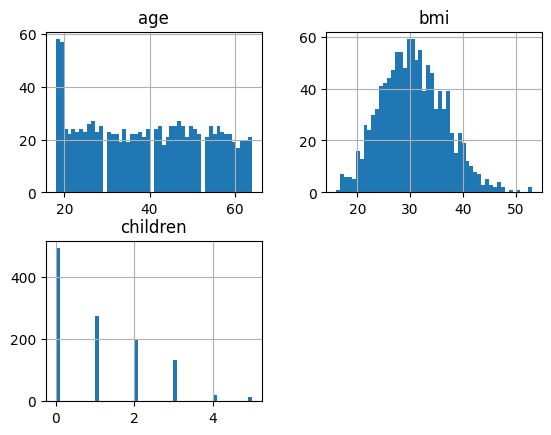

In [20]:
X_train.hist(bins=50)

# Test entre 2 méthodes

### init

In [21]:

from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, LassoCV, LinearRegression

from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.discretisation import ArbitraryDiscretiser

set_config(transform_output = "pandas")

alphas = np.linspace(50, 200, 20)
bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}

## Pipeline

In [22]:
pipe_bmi = make_pipeline(
    ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True),
    OneHotEncoder(variables=['bmi'])
)

transformers = make_column_transformer(
    (OneHotEncoder(variables=['region']), ['region']),
    (OrdinalEncoder(variables=['smoker', 'sex']), ['smoker', 'sex']),
    (pipe_bmi, ['bmi']),
    remainder='passthrough'
)

#np.set_printoptions(threshold=np.inf)

df_X_train = transformers.fit_transform(X_train, y_train)
df_X_train.head()

,onehotencoder__region_southeast,onehotencoder__region_southwest,onehotencoder__region_northwest,onehotencoder__region_northeast,ordinalencoder__smoker,ordinalencoder__sex,"pipeline__bmi_(18.5, 25.0]","pipeline__bmi_(25.0, 30.0]","pipeline__bmi_(30.0, 40.0]","pipeline__bmi_(40.0, inf]","pipeline__bmi_(-0.001, 18.5]",remainder__age,remainder__children
70,1,0,0,0,1,0,1,0,0,0,0,27,0
978,1,0,0,0,0,0,0,1,0,0,0,36,0
382,1,0,0,0,0,1,0,0,1,0,0,55,0
948,0,1,0,0,1,1,0,1,0,0,0,25,3
220,0,1,0,0,0,0,0,0,1,0,0,34,1


# Cook distance

## Visualisation

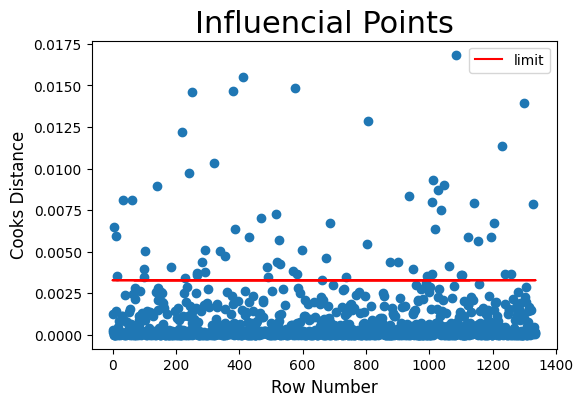

In [23]:
import statsmodels.api as sm

y_train_cook = y_train.copy()

df_X_train = sm.add_constant(df_X_train)
model_cook = sm.OLS(y_train_cook, df_X_train).fit()
influence = model_cook.get_influence()

#obtain Cook's distance for each observation
cooks = influence.cooks_distance 
mean_cooks = np.mean(cooks[0])
mean_cooks_list = [4 * mean_cooks for i in df_X_train.index]

# Draw plot
plt.figure(figsize = (6, 4))
plt.scatter(df_X_train.index, cooks[0])
#plt.plot(df_X_train.index, cooks[0], color='black')
plt.plot(df_X_train.index, mean_cooks_list, color="red", label='limit')
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influencial Points', fontsize = 22)
plt.legend()
plt.show()


## Points d'influence

In [24]:
# Influencial points
influencial_points = df_X_train.index[cooks[0] > 4 * mean_cooks]
influencial_points

Index([ 265,  673,  291, 1229,  598,  140, 1239, 1061,  380,  900,  526, 1299,
       1007,  266,  430,  582,  355,  292,  321,  242, 1327,    3, 1018, 1084,
       1046,  227,  802, 1011,  993, 1103,   62,  281,  250,    9, 1141,  875,
        530,  516, 1010,  491,  185,  468, 1257,  738,  412, 1026,   99,  340,
       1205,  950,  935, 1155,  102,  569, 1099,  687,  488,  219,  577, 1194,
       1038,   98,  520,   14,   34,  387,  805, 1123],
      dtype='int64')

## Suppression des points d'influence
Ne pas le faire sur le jeu de test

In [25]:
print(len(X_train), len(y_train), f'suppression de : {len(influencial_points)} points')

X_train.drop(index=influencial_points, inplace=True)
y_train.drop(index=influencial_points, inplace=True)

print(len(X_train), len(y_train))

1136 1136 suppression de : 68 points
1068 1068


## GridSearchSV

### Model fit

In [26]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
                    transformers, 
                    PolynomialFeatures(interaction_only=False), 
                    StandardScaler(),
                    Lasso(max_iter=1000000, tol=1e-4)
                )
#print(pipe.get_params()) --> pour récupérer les paramètres pour le cv du modèle
grid = GridSearchCV(pipe, {'lasso__alpha': alphas}, cv=3)
grid.fit(X_train, y_train)
print('best score : ', grid.best_score_)
print('best params : ', grid.best_params_)

best score :  0.9289465567050446
best params :  {'lasso__alpha': 81.57894736842105}


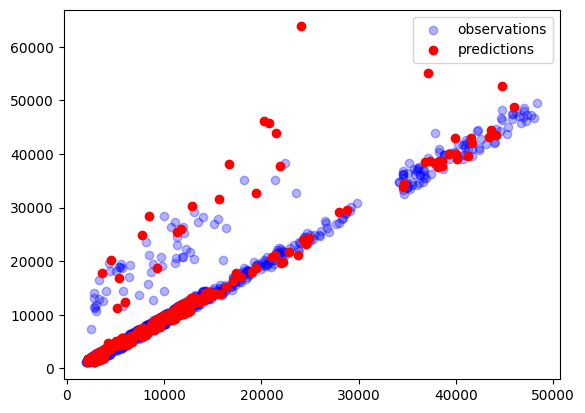

In [27]:
predictions = grid.best_estimator_.predict(X_test)
observations = grid.best_estimator_.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

### Sauvegarde du model

In [28]:
import pickle
model_path = 'data/model_grid.pickle'
save_comp = {
    'model': grid.best_estimator_
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

## LassoCV

### Model fit

In [29]:
pipe = make_pipeline(
            transformers,
            PolynomialFeatures(interaction_only=False), 
            #StandardScaler(with_mean=False),
            MinMaxScaler(),
            LassoCV(alphas=[65.78947368421052], fit_intercept=False, max_iter=1000000, cv=5)
        )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
#print(pipe.named_steps)
print('Score :', score)
print('RMSE :', mse)
print('alpha :', pipe.named_steps.lassocv.alpha_)

Score : 0.801023257059326
RMSE : 5949.351360073769
alpha : 65.78947368421052


### Sauvegarde du model

In [30]:
import pickle
model_path = 'data/model_cv.pickle'
save_comp = {
    'model': pipe
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

### Graph des prédictions

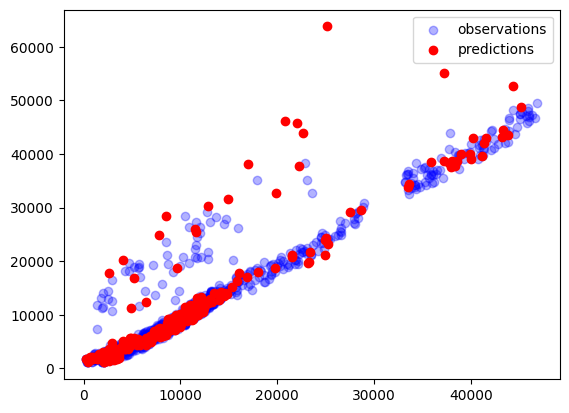

In [31]:
predictions = pipe.predict(X_test)
observations = pipe.predict(X_train)

plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()

# Discrétisation de bmi pour la démo

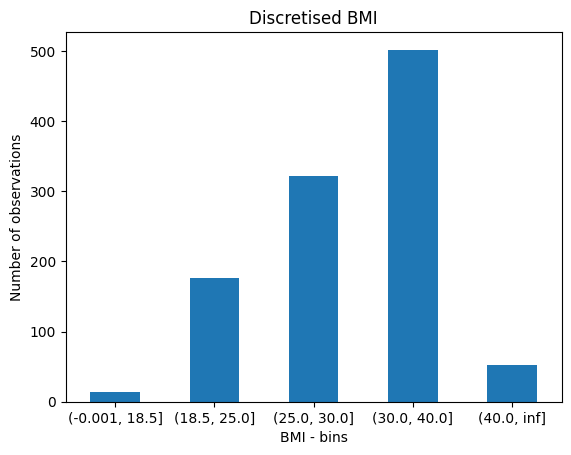

In [32]:
from feature_engine.discretisation import ArbitraryDiscretiser

bmi_dict = {'bmi': [0, 18.5, 25, 30, 40, np.Inf]}
transformer = ArbitraryDiscretiser(binning_dict=bmi_dict, return_object=False, return_boundaries=True)

bmi = transformer.fit_transform(X_train)
bmi['bmi'].value_counts(ascending=True).sort_index().plot.bar(rot=0)
plt.xlabel('BMI - bins')
plt.ylabel('Number of observations')
plt.title('Discretised BMI')
plt.show()

# chargement du model et prédiction

In [33]:
model_path = 'data/model_grid.pickle'
m = pickle.load(open(model_path, 'rb'))
model = m['model']

# test predict sur un individu
t = pd.DataFrame(
                [['no', 'male', 18, 15.0, 0, 'northeast']], 
                 columns = ['smoker', 'sex', 'age', 'bmi', 'children', 'region']
                 )
print(t.head())
model.predict(t)


  smoker   sex  age   bmi  children     region
0     no  male   18  15.0         0  northeast


array([2445.50508638])

## Regression linéaire

Score : 0.7758147600055529
MSE : 6314.979828397998


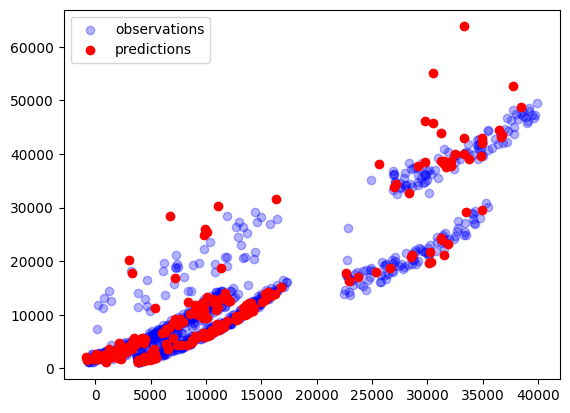

In [34]:
from sklearn.linear_model import LinearRegression

pipe = make_pipeline(
                    transformers, 
                    MinMaxScaler(),
                    LinearRegression()
                )

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)

predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

observations = pipe.predict(X_train)
plt.scatter(observations, y_train, color='blue', alpha=.3, label='observations')
plt.scatter(predictions, y_test, color='red', label='predictions')
plt.legend()